In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:

import keras 
import tensorflow as tf
import numpy as np 
import cv2 
import os
import matplotlib.pyplot as plt 
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input 
from keras.applications.vgg16 import VGG16, preprocess_input 
from keras.applications.resnet import  ResNet50 , preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
import seaborn as sns 
from numpy import genfromtxt
import keras.backend as K
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from time import time


In [ ]:
print(tf.__version__)

2.8.2


In [ ]:
 
size = 224
bs = 32
 
train_folder = '/content/drive/MyDrive/db3/fold1/train/images' 
test_folder = '/content/drive/MyDrive/db3/fold1/test/images'
 
train_data_gen = ImageDataGenerator()
train_data = train_data_gen.flow_from_directory(train_folder, class_mode='categorical', target_size=(size,size), color_mode='rgb', batch_size=bs)

test_data_gen = ImageDataGenerator()
test_data = test_data_gen.flow_from_directory(test_folder, class_mode='categorical', target_size=(size,size), shuffle=False)

Found 3600 images belonging to 30 classes.
Found 900 images belonging to 30 classes.


In [ ]:
a=len(test_data.class_indices)
print(a)

30


In [ ]:

labels = list(train_data.class_indices.keys())


In [ ]:

shape = train_data.image_shape
print("Eğitim görüntülerinin boyutu: ", shape)                    
k = train_data.num_classes
print("Toplam sınıf sayısı: ", k)                               
train_samples = train_data.samples
print("Toplam eğitim görüntüsü sayısı: ", train_samples)           
test_samples = test_data.samples
print("Toplam test görüntüsü sayısı: ", test_samples)              

Eğitim görüntülerinin boyutu:  (224, 224, 3)
Toplam sınıf sayısı:  30
Toplam eğitim görüntüsü sayısı:  3600
Toplam test görüntüsü sayısı:  900


In [ ]:
def googlenet(input_shape, n_classes):
  
  def inception_block(x, f):
    t1 = Conv2D(f[0], 1, activation='relu')(x)
    
    t2 = Conv2D(f[1], 1, activation='relu')(x)
    t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
    
    t3 = Conv2D(f[3], 1, activation='relu')(x)
    t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)
    
    t4 = MaxPool2D(3, 1, padding='same')(x)
    t4 = Conv2D(f[5], 1, activation='relu')(t4)
    
    output = Concatenate()([t1, t2, t3, t4])
    return output
  
  
  input = Input(input_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = Conv2D(64, 1, activation='relu')(x)
  x = Conv2D(192, 3, padding='same', activation='relu')(x)
  x = MaxPool2D(3, strides=2)(x)
  
  x = inception_block(x, [64, 96, 128, 16, 32, 32])
  x = inception_block(x, [128, 128, 192, 32, 96, 64])
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = inception_block(x, [192, 96, 208, 16, 48, 64])
  x = inception_block(x, [160, 112, 224, 24, 64, 64])
  x = inception_block(x, [128, 128, 256, 24, 64, 64])
  x = inception_block(x, [112, 144, 288, 32, 64, 64])
  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = inception_block(x, [256, 160, 320, 32, 128, 128])
  x = inception_block(x, [384, 192, 384, 48, 128, 128])
  
  x = AvgPool2D(7, strides=1)(x)
  x = Dropout(0.4)(x)
  
  x = Flatten()(x)
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [ ]:
model = googlenet(shape,a)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
# Modeli derleme
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)     # Adamax optimizerı
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:

ep = 50                      
spe = train_samples/bs       
ts = test_samples/bs        
  
r = model.fit(train_data, validation_data=test_data, steps_per_epoch=spe, validation_steps=ts, epochs=ep)

Epoch 1/50
112/112 [==============================] - 1560s 14s/step - loss: 3.2929 - accuracy: 0.0575 - val_loss: 2.7811 - val_accuracy: 0.1433
Epoch 2/50
112/112 [==============================] - 49s 432ms/step - loss: 2.3717 - accuracy: 0.2117 - val_loss: 1.9079 - val_accuracy: 0.3167
Epoch 3/50
112/112 [==============================] - 49s 436ms/step - loss: 1.7156 - accuracy: 0.3536 - val_loss: 1.2939 - val_accuracy: 0.4933
Epoch 4/50
112/112 [==============================] - 48s 422ms/step - loss: 1.3709 - accuracy: 0.4761 - val_loss: 1.0332 - val_accuracy: 0.6022
Epoch 5/50
112/112 [==============================] - 49s 431ms/step - loss: 1.2375 - accuracy: 0.5297 - val_loss: 1.0788 - val_accuracy: 0.5844
Epoch 6/50
112/112 [==============================] - 48s 425ms/step - loss: 0.8954 - accuracy: 0.6428 - val_loss: 0.6711 - val_accuracy: 0.7356
Epoch 7/50
112/112 [==============================] - 48s 423ms/step - loss: 0.8363 - accuracy: 0.6778 - val_loss: 0.5623 - val_ac

In [ ]:
 
model.evaluate(test_data)

29/29 [==============================] - 10s 328ms/step - loss: 0.1267 - accuracy: 0.9589


[0.12672413885593414, 0.9588888883590698]

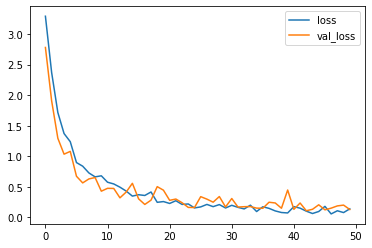

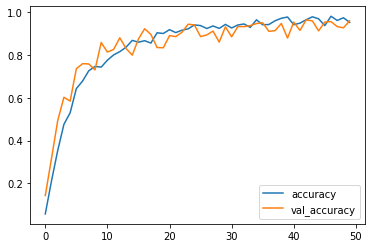

In [ ]:
 
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.plot(r.history['accuracy'], label='accuracy') 
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:

pred = model.predict(test_data).argmax(axis=1)
labels = list(train_data.class_indices.keys())   

In [ ]:
np.savetxt("g1.csv",pred)

In [ ]:
my_data = genfromtxt("g1.csv")


In [ ]:
np.savetxt("g1_test.csv",test_data.classes)
my_data_test=genfromtxt("g1_test.csv")

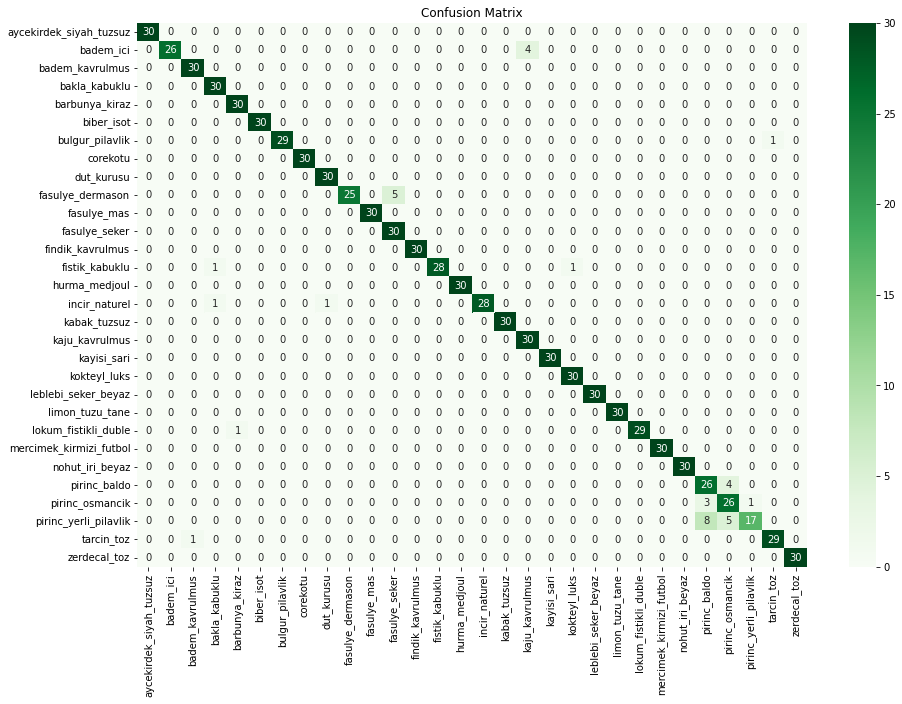

In [ ]:
cm = confusion_matrix(test_data.classes, my_data)
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels, cmap="Greens")  # cmap="BuPu"
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Test verileri tahmininde F1 puanı

print(classification_report(test_data.classes, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.97      0.97      0.97        30
           2       0.97      0.97      0.97        30
           3       0.97      0.97      0.97        30
           4       1.00      0.97      0.98        30
           5       1.00      1.00      1.00        30
           6       1.00      1.00      1.00        30
           7       0.97      1.00      0.98        30
           8       1.00      0.97      0.98        30
           9       0.90      0.93      0.92        30
          10       1.00      1.00      1.00        30
          11       1.00      0.90      0.95        30
          12       1.00      1.00      1.00        30
          13       1.00      1.00      1.00        30
          14       1.00      0.97      0.98        30
          15       1.00      0.93      0.97        30
          16       1.00      0.97      0.98        30
          17       0.93    